In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score, v_measure_score, pairwise_kernels, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import statsmodels.api as sm
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from tck.TCK import TCK
from tck.datasets import DataLoader
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.tensorPCA import tensorPCA
import time
from reservoir_computing.modules import RC_model
from reservoir_computing.utils import compute_test_scores

### Exercise 1

1. Compute the DTW distance matrix.
2. Obtain a similarity matrix from it.
3. Plot the two matrices. Comment about the structure you see (remember to sort the elements class-wise).
4. Perform classification with SVC and $k$-NN classifiers and report:
    - the training and test times,
    - the accuracy and the F1 score on the test set.
5. Perform hierarchical clustering using the Linkage Ward algorithm.
6. Plot a dendrogram and inspect it to select the optimal threshold to generate the clustering partition. Report the NMI for the partition you found.
7. Perform dimensionality reduction with KernelPCA. Plot the results in a 2-dimensional plot.

In [61]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)


In [29]:
# Compute the distance matrix
dtw_dist = dtw.distance_matrix_fast(Xtr)

# Plot the distance matrix
plt.figure(figsize=(4,4))
plt.imshow(dtw_dist, cmap='viridis')
plt.colorbar()
plt.show()

The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.


CythonException: The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.

### Exercise 2

1. Add 40% of missing values to the training and test data.
2. Compute the TCK kernel.
3. Compute a dissimilarity matrix from the kernel (try to do the complementary of what you did to obtain a similarity from DTW). 

Repeat points 4-7 from the previous exercise.

In [62]:
mask_tr = np.random.choice([0, 1], size=Xtr.shape, p=[0.6, 0.4])
Xtr[mask_tr == 1] = np.nan
mask_te = np.random.choice([0, 1], size=Xte.shape, p=[0.6, 0.4])
Xte[mask_te == 1] = np.nan

tck = TCK(G=30, C=15)
Ktr = tck.fit(Xtr).predict(mode='tr-tr')
Kte = tck.predict(Xte=Xte, mode='tr-te').T
print(f"Ktr shape: {Ktr.shape}\nKte shape: {Kte.shape}")

idx_sorted = np.argsort(Yte[:,0])

The dataset contains missing data

Training the TCK using the following parameters:
	C = 15, G = 30
	Number of MTS for each GMM: 144 - 180 (80 - 100 percent)
	Number of attributes sampled from [2, 2]
	Length of time segments sampled from [6, 25]




Fitting GMMs:   0%|          | 0/420 [00:00<?, ?it/s]

Computing TCK (tr-tr):   0%|          | 0/420 [00:00<?, ?it/s]

Computing TCK (tr-te):   0%|          | 0/420 [00:00<?, ?it/s]

Ktr shape: (180, 180)
Kte shape: (180, 180)


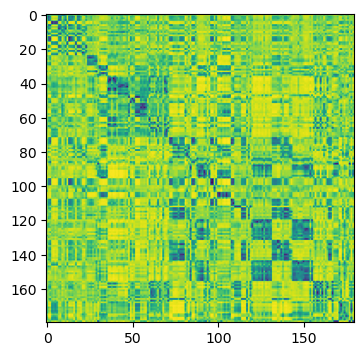

In [63]:
# Shift from similarity to dissimilarity by standartizing it in the range [0, 1] and subtracting by 1:

Ktr = (Ktr - Ktr.min()) / (Ktr.max() - Ktr.min())
Ktr = 1 - Ktr
Kte = (Kte - Kte.min()) / (Kte.max() - Kte.min())
Kte = 1 - Kte


fig =  plt.figure(figsize=(4,4))
plt.imshow(Kte[idx_sorted][:, idx_sorted]);

Classification with TCK kernel using SVC:

In [38]:
# Fit the classifier
start_time = time.time()
clf = svm.SVC(kernel="linear")
clf.fit(Ktr, Ytr)

# Compute predictions and accuracy
y_pred = clf.predict(Kte)

end_time = time.time()

y_pred.size, Yte.size
# accuracy, f1 = compute_test_scores(y_pred, Yte)
f1 = f1_score(Ytr, y_pred, average='macro')  # or 'micro', 'weighted'
accuracy = accuracy_score(Ytr, y_pred)

print(f"Execution time: {end_time - start_time:.6f} seconds")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")

Execution time: 0.010879 seconds
Accuracy: 0.6888888888888889
F1 score: 0.6699582421138486


Now the same, but using KNN

In [40]:
start_train = time.time()
knn = KNeighborsClassifier(n_neighbors=3, metric='precomputed')
knn.fit(Ktr, Ytr)

start_test = time.time()
y_pred_knn = knn.predict(Kte)
test_time = time.time() - start_test

f1 = f1_score(Ytr, y_pred_knn, average='macro')  # or 'micro', 'weighted'
accuracy = accuracy_score(Ytr, y_pred_knn)

print(f"Execution time: {end_time - start_time:.6f} seconds")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")

Execution time: 0.010879 seconds
Accuracy: 0.6833333333333333
F1 score: 0.6711450720900436


Clustering using TCK kernel:

Mutual Information: 0.5287953076721414


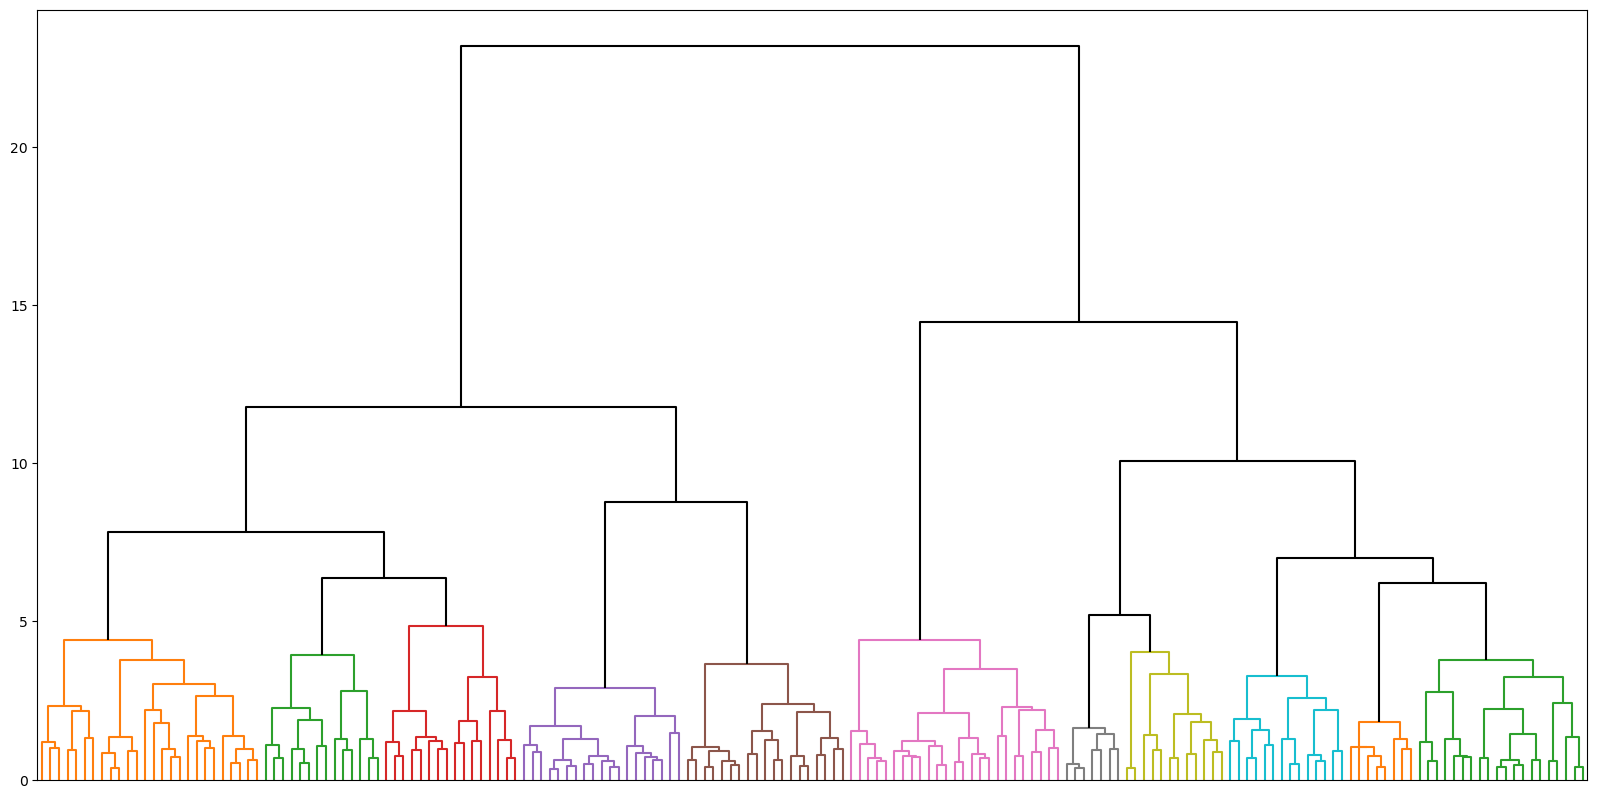

In [46]:
Z = linkage(Kte, 'ward')

partition = fcluster(Z, t=5, criterion="distance")
MI = v_measure_score(partition, Yte.ravel())
print(f"Mutual Information: {MI}")

fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=5, above_threshold_color='k', 
                show_leaf_counts=False)
plt.xticks([])
plt.show()

Dimensionality reduction:

([], [])

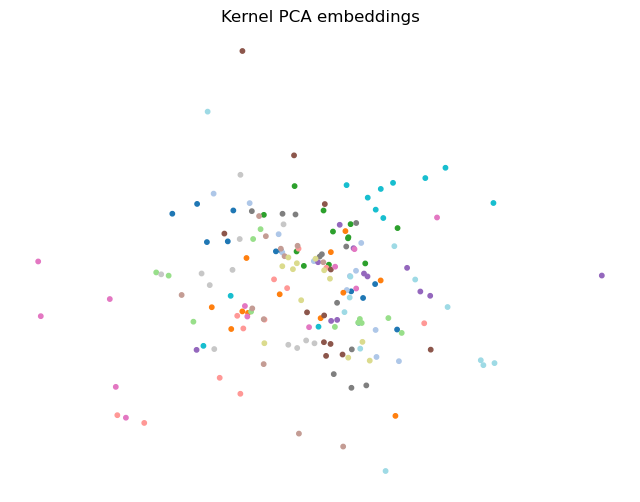

In [79]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(Kte)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Yte.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(())

Dimensionality reduction using PCA does not give any meaningfull information. On the other hand, kNN and SVC have decent performances when using TCK kernel.

### Exercise 3

1. Compute the RC embeddings.
2. Obtain a similarity and a dissimilarity matrix from the MTS representations.

Repeat points 4-7 from the previous exercises.

Let's use bidirectional reservoir to embed the TS. I need to reload the data since I put NaNs for previous exercise.

Basically, we will try a linear model to reconstruct the next sample of the reservoir model. By doing so, if the performances of the regressor are good, I will end up with a model (the regressor) capable of extracting meaningfull features from the MTA. This will be my embedding. Then, I know that the embedded MTS will have a linear relationship between them ,so I can use any linear distance as kernel to get the similarity/dissimilarity matrix.


In [66]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

config = {}

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.9         # largest eigenvalue of the reservoir
config['leak'] = None                   # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circle'] = False                # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] = 'tenpca'      # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation: {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout
config['readout_type'] = None


rcm =  RC_model(**config)

# Generate representations of the input MTS
rcm.fit(Xtr)
trainig_RC_embedding = rcm.input_repr

rcm.fit(Xte)
test_RC_embedding = rcm.input_repr

print(trainig_RC_embedding.shape)

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)
Training completed in 0.02 min
Training completed in 0.02 min
(180, 5700)


Now I can apply the linear kernel to create the similarity matrix. Let's try standard euclidean distance. 

The to get the matrixes, rescale the distance in the range [0, 1] and obtain the dissimilarity as 1-similarity.

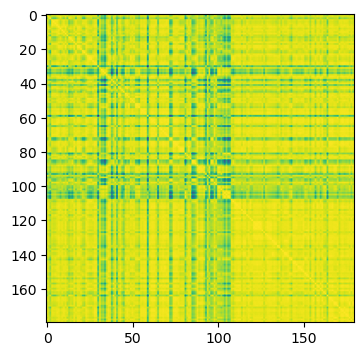

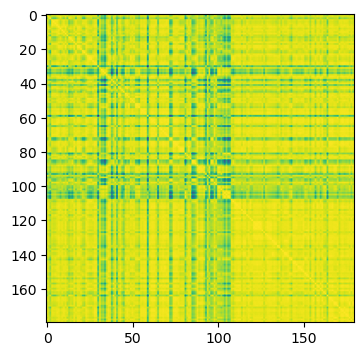

In [73]:
# Compute Dissimilarity matrix
Dist =  pairwise_distances(trainig_RC_embedding, metric="sqeuclidean")
RC_similarity_train = (Dist - Dist.min()) / (Dist.max() - Dist.min())
RC_dissimilarity_train = 1 - RC_similarity_train


Dist =  pairwise_distances(test_RC_embedding, metric="sqeuclidean")
RC_similarity_test = (Dist - Dist.min()) / (Dist.max() - Dist.min())
RC_dissimilarity_test = 1 - RC_similarity_test


Y = np.concatenate((Ytr, Yte), axis=0)
idx_sorted = np.argsort(Yte[:,0])

fig =  plt.figure(figsize=(4,4))
plt.imshow(RC_dissimilarity_train[:,idx_sorted][idx_sorted,:]);
fig =  plt.figure(figsize=(4,4))
plt.imshow(RC_dissimilarity_train[:,idx_sorted][idx_sorted,:]);

Classification with SVC uwing RC kernel:

In [75]:
# Fit the classifier
start_time = time.time()
clf = svm.SVC(kernel="linear")
clf.fit(RC_dissimilarity_train, Ytr)

# Compute predictions and accuracy
y_pred = clf.predict(RC_dissimilarity_test)

end_time = time.time()

y_pred.size, Yte.size
# accuracy, f1 = compute_test_scores(y_pred, Yte)
f1 = f1_score(Yte, y_pred, average='macro')  # or 'micro', 'weighted'
accuracy = accuracy_score(Yte, y_pred)

print(f"Execution time: {end_time - start_time:.6f} seconds")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")

Execution time: 0.003691 seconds
Accuracy: 0.1
F1 score: 0.06522709885702808


Classifincation iwth kNN:

In [76]:
start_train = time.time()
knn = KNeighborsClassifier(n_neighbors=3, metric='precomputed')
knn.fit(RC_dissimilarity_train, Ytr)

start_test = time.time()
y_pred_knn = knn.predict(RC_dissimilarity_test)
test_time = time.time() - start_test

f1 = f1_score(Yte, y_pred_knn, average='macro')  # or 'micro', 'weighted'
accuracy = accuracy_score(Yte, y_pred_knn)

print(f"Execution time: {end_time - start_time:.6f} seconds")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")

Execution time: 0.003691 seconds
Accuracy: 0.08333333333333333
F1 score: 0.04614600107353731


Clustering and dendrogram

Mutual Information: 0.12686336931453956


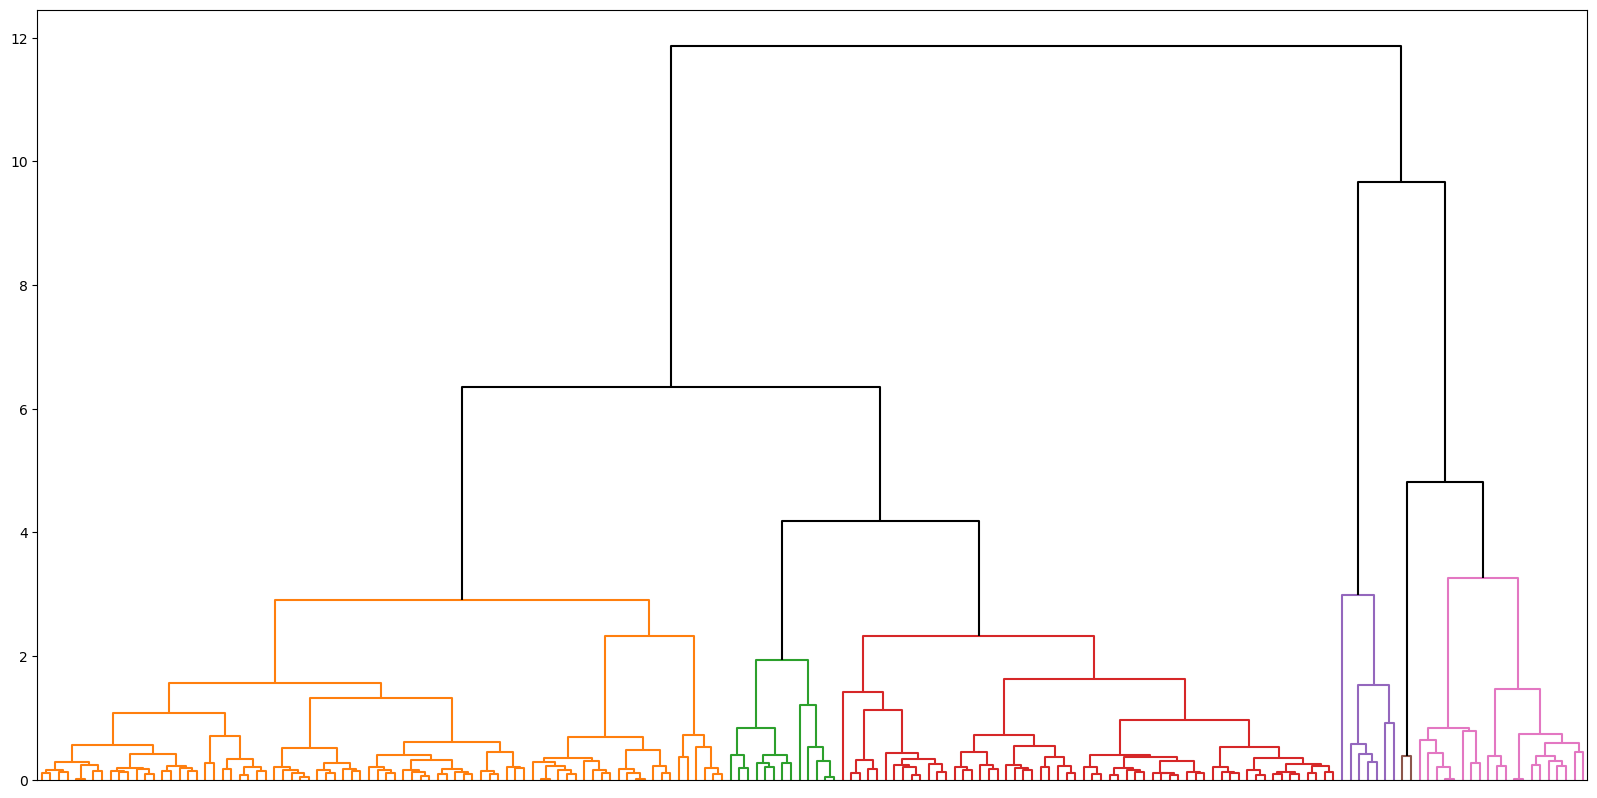

In [78]:
Z = linkage(RC_dissimilarity_test, 'ward')

partition = fcluster(Z, t=5, criterion="distance")
MI = v_measure_score(partition, Yte.ravel())
print(f"Mutual Information: {MI}")

fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=4, above_threshold_color='k', 
                show_leaf_counts=False)
plt.xticks([])
plt.show()

([], [])

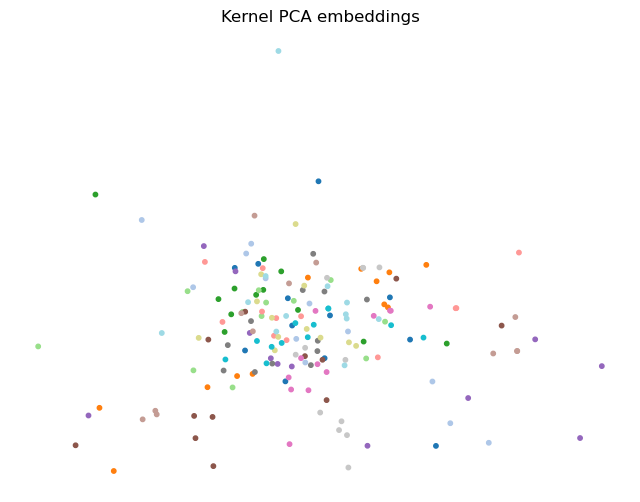

In [80]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(RC_dissimilarity_test)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Yte.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(())

Using RC for embedding does not provide a good enaugh linear rapresentation of the distance between the MTS. Percormances of kNN and SVC are pretty bad indeed.